# Eviroment Setup

In [1]:
import seaborn as sns
import numpy as np
import math
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report

from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.constraints import maxnorm
from tensorflow.keras.callbacks import LearningRateScheduler

# Import Data

In [4]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [2]:

x_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/x_train.csv', index_col='ID')
y_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/x_test.csv', index_col='ID')

# Data Exploration

In [ ]:
print(train.shape)
print(train.dtypes)
train.head(20)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([0.00000e+00, 1.80000e+01, 4.39700e+03, 1.32118e+05, 1.75724e+05,
        2.56880e+04, 7.32300e+03, 3.17700e+03, 1.62600e+03, 9.54000e+02]),
 array([-4. , -3.1, -2.2, -1.3, -0.4,  0.5,  1.4,  2.3,  3.2,  4.1,  5. ]),
 <a list of 10 Patch objects>)

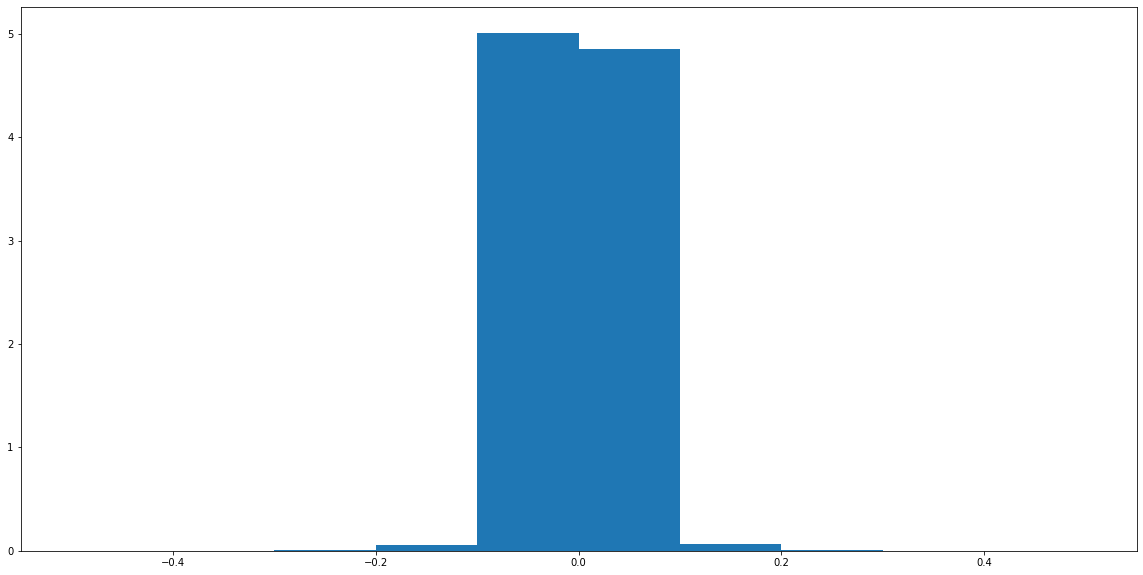

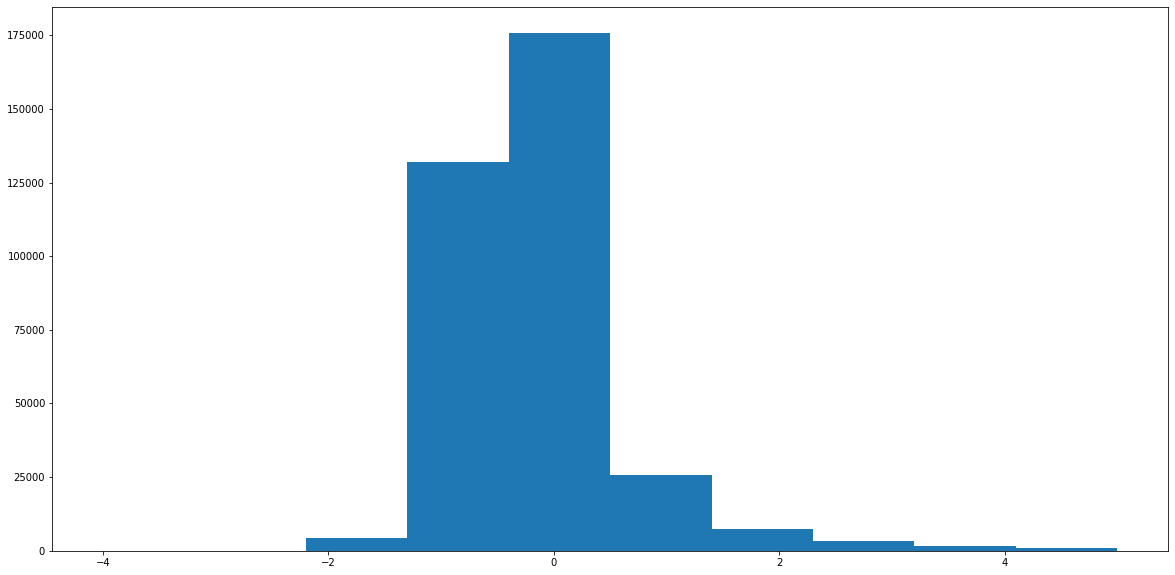

In [ ]:
column = ["RET_1", "RET_2","RET_3", "RET_4", "RET_5"]
plt.figure(figsize=[20,10])
plt.hist(train["RET_4"], density=True, range=(-0.5,0.5))
plt.figure(figsize=[20,10])
plt.hist(train["VOLUME_1"], density=False, range=(-4,5))


In [ ]:
train.groupby(["RET"]).count()


,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,RET_3,VOLUME_3,RET_4,VOLUME_4,RET_5,VOLUME_5,RET_6,VOLUME_6,RET_7,VOLUME_7,RET_8,VOLUME_8,RET_9,VOLUME_9,RET_10,VOLUME_10,RET_11,VOLUME_11,RET_12,VOLUME_12,RET_13,VOLUME_13,RET_14,VOLUME_14,RET_15,VOLUME_15,RET_16,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20
RET,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,209749,209749,209749,209749,209749,209749,208576,177194,208518,176307,208503,175329,208482,173741,208459,171893,208460,171892,208471,172409,208440,172383,208416,172795,208420,172786,208269,173644,208192,178502,208095,180146,207640,178932,207342,176158,207213,175657,207208,178250,207202,175593,207197,175614,207194,175345
True,208846,208846,208846,208846,208846,208846,207660,176376,207612,175902,207585,175447,207569,173857,207552,172009,207538,171989,207539,172333,207532,172314,207497,172502,207483,172504,207365,172926,207217,177570,207140,179441,206542,178734,206263,176064,206102,175676,206086,178031,206086,175416,206085,175652,206060,175393


## Observation 
There are 5350 of unique stock and 156 date [0, 223] (The train data and test data have been split by DATE, so test data contain the data of the DATE that are not included in side train data). Each STOCK existe only one inside one DATE. RET_1 is the return at day (t-1) respectively RET_20 is the return at (day-20). </br>
VOLUME_1 is the performance of each stock at day (t-1) which is the sum of tolal sale and total bought of that stock, respectively for VOLUME_20. </br>
Inside each DATE, there are maximum 3031 line of STOCK.

Most of the distribution of RET_i is lay around 0 and each RET_i has almost identical distribution. 
The distribution of VOLUME_i is positively skewed. the majority of value is negative [-0.4, -0.2]. similarly to RET, all VOLUME has similay distribution. 

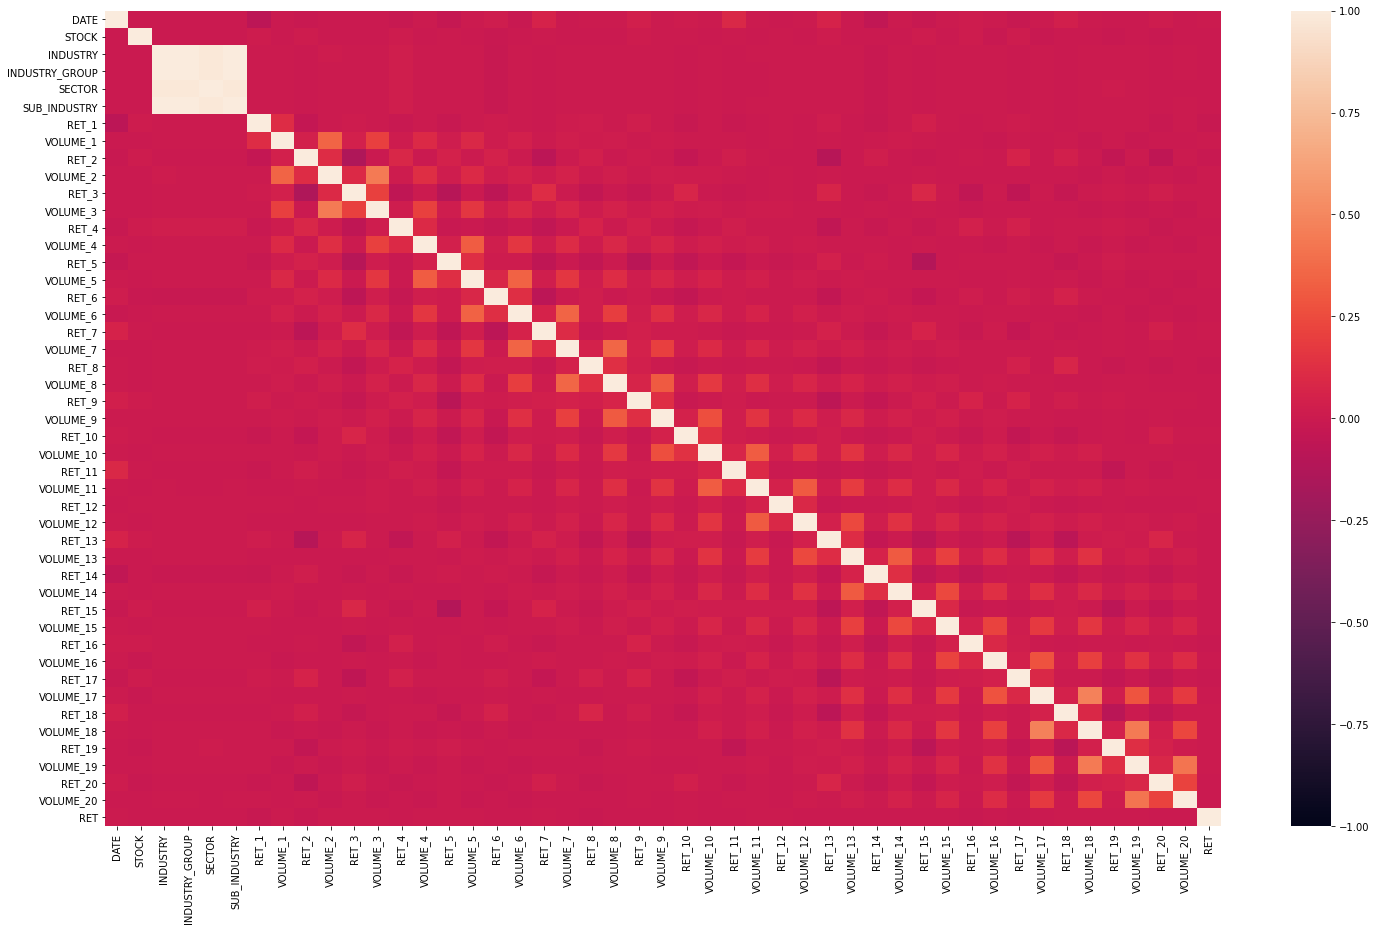

In [ ]:
figure = plt.figure(figsize=[25,15])
sns.heatmap(train.corr(), vmin=-1, vmax=1)

## Observation on correlation
- INDUSTRY and SECTOR are highly correlated. 
- VOLUME_i is noticable correlated to the VOLUME_(i+1) which mean the return from day (t) is correlated to the return of day (t-1) and the relation decrease respectively.
- There is low correlation between the data and label, a linear model would not work in this case,  so the nonlinear model should be considered. 

## Missing Value

In [ ]:
train.isnull().sum()

DATE                  0
STOCK                 0
INDUSTRY              0
INDUSTRY_GROUP        0
SECTOR                0
SUB_INDUSTRY          0
RET_1              2359
VOLUME_1          65025
RET_2              2465
VOLUME_2          66386
RET_3              2507
VOLUME_3          67819
RET_4              2544
VOLUME_4          70997
RET_5              2584
VOLUME_5          74693
RET_6              2597
VOLUME_6          74714
RET_7              2585
VOLUME_7          73853
RET_8              2623
VOLUME_8          73898
RET_9              2682
VOLUME_9          73298
RET_10             2692
VOLUME_10         73305
RET_11             2961
VOLUME_11         72025
RET_12             3186
VOLUME_12         62523
RET_13             3360
VOLUME_13         59008
RET_14             4413
VOLUME_14         60929
RET_15             4990
VOLUME_15         66373
RET_16             5280
VOLUME_16         67262
RET_17             5301
VOLUME_17         62314
RET_18             5307
VOLUME_18       

In [3]:
#Replacing RET_i nan with 0
rets = ["".join(["RET_",str(i)]) for i in range(1,20)]
train[rets] = train[rets].fillna(0)


#Replacing nan in VOLUME with mean
for i in range(1,20):
  col = "".join(["VOLUME_",str(i)])
  train[col] = train[col].fillna(train[col].mean())
  test[col] = test[col].fillna(test[col].mean())
"""
print("Before:",train.shape)
(train.dropna(how='any', inplace=True))
print("After:",train.shape)
print("--------------------")
print("Test - Before:",test.shape)
(test.dropna(how='any', inplace=True))
print("Test - After:",test.shape)
"""
train.head(20)

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,RET_3,VOLUME_3,RET_4,VOLUME_4,RET_5,VOLUME_5,RET_6,VOLUME_6,RET_7,VOLUME_7,RET_8,VOLUME_8,RET_9,VOLUME_9,RET_10,VOLUME_10,RET_11,VOLUME_11,RET_12,VOLUME_12,RET_13,VOLUME_13,RET_14,VOLUME_14,RET_15,VOLUME_15,RET_16,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,0.010972,0.033832,-0.014672,-0.362868,0.016483,-0.972920,0.014331,0.590810,-0.017215,0.557246,-0.018433,0.453590,0.134146,8.580442,0.182287,3.427303,0.013570,-0.328418,0.030108,-0.816436,0.027624,-0.244636,-0.049370,-2.042624,-0.028571,-0.369605,0.059459,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,-0.071502,-0.090580,-0.075230,0.018826,-0.097235,-0.025540,-0.088976,-0.038062,-0.092163,-0.006873,-0.100510,-0.026756,-0.084714,0.023973,-0.087037,0.158731,-0.090863,0.045642,-0.092151,-0.008230,-0.084261,-0.028000,-0.080856,-0.019608,-0.075401,-0.052044,-0.072426,-0.004073,-0.085919,0.015413,-0.076018,0.003774,-0.087854,-0.018518,-0.076147,-0.028777,-0.076496,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,-0.009042,-0.298777,0.024852,-0.157421,0.009354,0.091455,0.027522,-0.405978,-0.023047,-0.389777,-0.002979,-0.701838,-0.006342,-0.229531,0.055803,0.543460,-0.012781,-0.121126,0.028093,-0.187444,-0.009426,-0.081783,-0.002686,-0.356711,-0.007552,-0.336773,0.008964,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,-0.004632,-0.639737,-0.019677,-0.940163,0.003544,-0.882464,-0.002021,-0.113951,-0.043962,-0.395345,-0.004329,-0.765754,0.014146,-0.593888,-0.021946,0.588171,0.007693,-0.427358,0.007264,-0.540519,-0.010067,-0.839232,0.000479,-2.144763,0.021057,-0.431029,-0.031769,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,0.000000,-1.180629,0.000000,-1.313896,0.022321,-1.204398,0.018182,-0.879172,-0.026549,-0.858613,-0.017391,-0.029690,-0.008621,-1.022991,0.022026,-0.387114,-0.008734,-0.288180,-0.004348,-0.115091,-0.041667,0.271702,0.095891,18.894266,-0.026667,0.803608,-0.038461,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False
5,0,23,37,12,5,94,0.010938,-0.238878,0.021548,-0.322706,-0.016097,0.747003,-0.027120,0.688104,-0.007958,-0.182443,-0.012719,0.014338,-0.002612,-0.424833,-0.042515,1.054858,-0.002851,-0.510536,0.027829,-0.304632,-0.004011,-0.053529,0.010316,-0.187437,0.005186,-0.638832,0.005587,0.437913,-0.002601,0.078789,0.025915,-0.062753,-0.004552,-0.097196,0.012677,-0.331521,0.032527,0.665084,0.008400,-0.037627,False
6,0,45,52,18,7,121,0.010602,-0.139011,-0.015338,-0.242468,-0.014900,-0.262839,-0.004804,-0.327501,0.002512,-0.185445,0.007383,-0.057506,-0.020859,-0.039475,-0.013045,-0.202530,0.011338,0.346935,0.016768,-0.391000,-0.006249,-0.195913,0.007978,-0.337275,0.007190,-0.235200,-0.004630,-0.943145,-0.009796,-0.254915,0.007983,-0.273181,-0.003767,0.296727,0.022470,0.158390,-0.005110,-0.219619,0.006428,-0.189815,False
7,0,59,57,20,8,143,0.001608,0.351362,-0.040863,-0.274854,-0.005444,-0.389846,0.000077,-0.469694,-0.007610,-0.263894,-0.006052,-0.288954,-0.009737,-0.266348,0.002252,-0.754402,0.009091,-0.468525,0.006097,-0.645362,0.021807,-0.170219,-0.003106,0.020632,-0.011512,-0.362547,0.000000,0.530099,0.005401,-0.430796,0.016471,0.008281,0.043372,-0.085970,-0.012924,-0.256353,-0.034321,-0.348341,0.011839,-0.811403,False
8,0,60,46,16,7,108,0.022012,-0.071502,-0.018519,-0.075230,0.023159,-0.097235,0.005290,-0.088976,0.000000,-0.092163,0.021621,-0.100510,0.000000,-0.084714,0.002167,-0.087037,-0.023280,-0.090863,-0.020725,-0.092151,-0.015307,-0.084261,0.005129,-0.080856,0.023085,-0.075401,0.030270,-0.072426,0.00000

## Missing Value Observation
In boths train and test data, there are around 25% of data has missing value. Most of data in VOLUME_i are missing completely. 
### Dealing
- All the RET_i value that are missing will replace by 0 which mean that stock has no evolution.
- All the VOLUME_i value that are missing will replace by MEAN of each column

## Verify train and test statistical aspect


In [ ]:
pd.options.display.max_columns = None
train.describe()


,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,RET_3,VOLUME_3,RET_4,VOLUME_4,RET_5,VOLUME_5,RET_6,VOLUME_6,RET_7,VOLUME_7,RET_8,VOLUME_8,RET_9,VOLUME_9,RET_10,VOLUME_10,RET_11,VOLUME_11,RET_12,VOLUME_12,RET_13,VOLUME_13,RET_14,VOLUME_14,RET_15,VOLUME_15,RET_16,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20
count,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,418595.000000,413254.000000,350738.000000
mean,108.659002,3373.567833,37.176020,12.697959,5.483845,90.391663,0.001375,-0.071502,0.000967,-0.075230,0.002140,-0.097235,-0.000675,-0.088976,0.000355,-0.092163,-0.000259,-0.100510,0.000328,-0.084714,0.000123,-0.087037,-0.000617,-0.090863,0.000005,-0.092151,-0.000775,-0.084261,0.000907,-0.080856,0.001338,-0.075401,0.002442,-0.072426,0.001824,-0.085919,0.001061,-0.076018,0.001621,-0.087854,0.001117,-0.076147,-0.000788,-0.076496,-0.000027,-0.076337
std,61.891642,1533.157749,19.706505,7.231701,2.410113,47.491157,0.031223,2.792688,0.030896,2.417543,0.031238,2.280143,0.031129,1.577193,0.031788,1.675914,0.031214,1.530923,0.030870,1.669572,0.031607,1.448114,0.032793,1.686811,0.031587,1.501675,0.030624,1.509572,0.186607,2.102386,0.032226,1.945975,0.030220,2.142035,0.032381,2.118401,0.029351,2.002447,0.031712,1.932285,0.031235,2.218897,0.030543,2.042496,0.033347,2.721355
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.845324,-2.434414,-0.770751,-3.007262,-0.740406,-3.370420,-0.863554,-2.390423,-0.792839,-1.810006,-0.723077,-2.294692,-0.660297,-2.157253,-0.806159,-2.219663,-0.896307,-4.020258,-0.753419,-2.572906,-0.755627,-2.184149,-0.807084,-2.357872,-0.828125,-4.228308,-0.827586,-5.148646,-0.816000,-4.388973,-0.765478,-5.600056,-0.825014,-4.610393,-0.876157,-4.167784,-0.880000,-2.341887,-0.785714,-2.768928
25%,56.000000,2478.000000,22.000000,6.000000,4.000000,49.000000,-0.010878,-0.499439,-0.011211,-0.485612,-0.009678,-0.479656,-0.012695,-0.467942,-0.012146,-0.480109,-0.012195,-0.486620,-0.011321,-0.482276,-0.012187,-0.488582,-0.012895,-0.503951,-0.012567,-0.500464,-0.013291,-0.494432,-0.012048,-0.506789,-0.010118,-0.505497,-0.009810,-0.508238,-0.010582,-0.492368,-0.010328,-0.477586,-0.011112,-0.499797,-0.010743,-0.484556,-0.011924,-0.474819,-0.011682,-0.542790
50%,104.000000,3560.000000,43.000000,15.000000,6.000000,104.000000,0.000521,-0.184287,0.000251,-0.179282,0.000794,-0.179915,-0.000365,-0.171355,0.000000,-0.169181,0.000000,-0.173629,0.000000,-0.172273,0.000000,-0.175308,0.000000,-0.181225,0.000000,-0.179127,-0.000423,-0.178485,0.000000,-0.195473,0.000979,-0.205347,0.000835,-0.201826,0.000548,-0.184398,0.000245,-0.174785,0.000000,-0.194525,0.000000,-0.181487,0.000000,-0.180194,0.000000,-0.283405
75%,161.000000,4606.000000,53.000000,19.000000,7.000000,128.000000,0.012857,-0.034459,0.012228,-0.038894,0.012732,-0.048396,0.010710,-0.052416,0.011204,-0.058769,0.011615,-0.060587,0.012364,-0.059223,0.011375,-0.058396,0.011267,-0.059352,0.011948,-0.055074,0.011101,-0.050961,0.012384,-0.037975,0.013071,-0.038715,0.013341,-0.040300,0.012722,-0.050500,0.011886,-0.046231,0.012639,-0.045061,0.011969,-0.049795,0.011030,-0.049075,0.011712,0.035795
max,223.000000,5716.000000,74.000000,26.000000,11.000000,182.000000,1.444990,1232.174009,1.427746,632.268279,3.086617,938.408298,2.243749,440.871746,1.491705,452.669715,2.810885,292.893500,1.512062,333.758405,2.290456,191.951947,2.471602,389.035576,1.999950,220.736417,1.355075,

In [ ]:
test.describe()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,RET_3,VOLUME_3,RET_4,VOLUME_4,RET_5,VOLUME_5,RET_6,VOLUME_6,RET_7,VOLUME_7,RET_8,VOLUME_8,RET_9,VOLUME_9,RET_10,VOLUME_10,RET_11,VOLUME_11,RET_12,VOLUME_12,RET_13,VOLUME_13,RET_14,VOLUME_14,RET_15,VOLUME_15,RET_16,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20
count,198429.000000,198429.000000,198429.000000,198429.00000,198429.000000,198429.000000,198421.000000,198429.000000,198412.000000,198429.000000,198407.000000,198429.000000,198396.000000,198429.000000,198387.000000,198429.000000,198384.000000,198429.000000,198383.000000,198429.000000,198385.000000,198429.000000,198389.000000,198429.000000,198369.000000,198429.000000,197376.000000,198429.000000,198263.000000,198429.000000,198155.000000,198429.000000,196767.000000,198429.000000,196410.000000,198429.000000,197104.000000,198429.000000,197031.000000,198429.000000,196847.000000,198429.000000,196853.000000,198429.000000,196854.000000,169818.000000
mean,117.856518,2964.731073,37.039717,12.65882,5.491788,89.977624,0.000415,-0.088807,0.001664,-0.088396,0.002431,-0.096557,-0.000337,-0.102336,0.000104,-0.116809,-0.001108,-0.107424,0.000781,-0.137158,0.002015,-0.172850,0.004601,-0.152554,-0.001820,-0.143173,0.000834,-0.184131,0.001252,-0.126097,0.002987,-0.096555,0.002510,-0.124741,-0.004437,-0.094149,0.002581,-0.185382,0.001301,-0.088977,-0.000850,-0.121587,-0.000413,-0.108951,-0.003291,-0.105200
std,69.370076,1690.573177,20.115079,7.36511,2.476564,48.365029,0.029991,4.733108,0.030485,6.179460,0.030072,1.332052,0.031016,1.829316,0.029933,1.725809,0.031132,3.670134,0.035334,2.216419,0.038986,1.768635,0.036242,1.780852,0.033424,2.147545,0.031666,1.789311,0.032308,2.046616,0.035136,1.998807,0.029720,1.847284,0.033353,3.909102,0.029951,3.211725,0.030364,3.738595,0.029716,2.778477,0.031732,3.665627,0.031586,4.974062
min,2.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-0.695866,-2.257694,-0.758577,-2.481697,-0.998274,-2.230799,-0.750000,-1.855339,-0.928571,-2.153766,-0.897206,-1.957858,-0.788075,-3.245695,-0.820090,-3.747606,-0.857143,-3.630378,-0.676470,-3.007794,-0.839506,-3.729035,-0.781607,-4.588448,-0.816415,-2.368636,-0.770833,-4.639543,-0.780099,-2.132919,-0.915972,-6.547718,-0.853511,-9.269120,-0.793552,-2.367021,-0.922714,-4.152110,-0.772469,-2.384668
25%,45.000000,1518.000000,20.000000,5.00000,3.000000,47.000000,-0.010251,-0.468785,-0.010080,-0.470694,-0.009475,-0.467229,-0.012701,-0.465363,-0.011246,-0.472453,-0.012487,-0.489090,-0.010989,-0.502172,-0.010311,-0.534855,-0.009217,-0.523710,-0.014899,-0.515582,-0.012862,-0.514466,-0.011125,-0.487614,-0.012092,-0.490949,-0.009042,-0.506124,-0.017746,-0.494201,-0.008851,-0.500963,-0.010527,-0.491715,-0.012720,-0.498155,-0.013136,-0.470966,-0.015685,-0.521530
50%,131.000000,3162.000000,43.000000,15.00000,6.000000,104.000000,0.001160,-0.191925,0.001513,-0.199360,0.001694,-0.189234,0.000000,-0.187664,0.000000,-0.184638,-0.000530,-0.190066,0.001095,-0.198704,0.000856,-0.211585,0.002396,-0.202242,-0.000939,-0.207143,0.000000,-0.206787,0.000911,-0.198450,0.000753,-0.202146,0.001443,-0.204981,-0.002593,-0.194190,0.001486,-0.203187,0.000916,-0.191767,-0.000296,-0.208214,-0.001480,-0.174232,-0.001382,-0.272407
75%,176.000000,4376.000000,53.000000,19.00000,7.000000,126.000000,0.012461,-0.044149,0.013365,-0.040629,0.013363,-0.036770,0.012009,-0.048851,0.011050,-0.055972,0.010295,-0.061800,0.013499,-0.059625,0.012815,-0.074821,0.015413,-0.063821,0.010989,-0.052970,0.012793,-0.049432,0.013363,-0.029058,0.015105,-0.031707,0.013176,-0.052090,0.009399,-0.046366,0.013196,-0.046397,0.012578,-0.047430,0.011268,-0.050619,0.009970,-0.046735,0.010045,0.016318
max,222.000000,5716.000000,74.000000,26.00000,11.000000,182.000000,0.981817,1830.743520,2.768073,2133.470634,1.675862,237.151802,1.386491,303.733101,1.289212,287.539693,1.327396,1419.529136,1.700003,604.283137,8.988892,298.695001,1.649007,394.917879,1.600000,491.925650,1.458155,3

## Statistic aspect observation
Some column has a very difference statistical aspect (mean, standard deviation), this could lead to the risk that the trained model does not perform well in the testing result due to training data does not representing the entire population of data.

# Feature Engineering

The main drawback in this challenge would be to deal with the noise. To do that, we could create some feature that aggregate features with some statistics. 

The following cell computes statistics on a given target conditionally to some features. For example, we want to generate a feature that describe the mean of `RET_1` conditionally to the `SECTOR` and the `DATE`.

**Ideas of improvement**: change shifts, the conditional features, the statistics, and the target. 

In [4]:
# Feature engineering 
new_features = []

# Conditional aggregated features
shifts = [1,2,3,4,5,6]  # Choose some different shifts
statistics = ['mean']  # the type of stat
gb_features = ['DATE', 'INDUSTRY']
target_feature = 'RET'
tmp_name = '_'.join(gb_features)
for shift in shifts:
    for stat in statistics:
        name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
        feat = f'{target_feature}_{shift}'
        new_features.append(name)
        for data in [train, test]:
            data[name] = data.groupby(gb_features)[feat].transform(stat)

# Feature engineering   2
By using the principle that the time serie data t+1 deped on the data t, so can try caculating new feature by using the average of the last few days.

In [5]:
use_columns= ["RET_1","RET_2","RET_3","RET_4"]

def weighted_sum(obs):
  count=0
  ws=0
  #print(len(obs))
  for fe in obs:
    ws += fe
    count+=1
  return ws/count * 100
train["4days_sum"] = [weighted_sum(obs) for obs in train[use_columns].values]
test["4days_sum"] = [weighted_sum(obs) for obs in test[use_columns].values]

In [ ]:

train[["4days_sum","RET"]].corr()

## Scaling RET to percentage
As VOLUME is larger than the RET, it could influence more to the result than RET, so transforming RET into percentage by multiply RET by 100 it increase to similare range

In [6]:

# Conditional aggregated features
shifts = [1,2,3,4,5,9, 10,11,13,14,17,19]  # Choose some different shifts
target_feature = 'RET'
tmp_name = 'x100'
for shift in shifts:
  name = f'{target_feature}_{shift}_{tmp_name}'
  feat = f'{target_feature}_{shift}'
  new_features.append(name)
  for data in [train, test]:
      data[name] = data[feat].transform(lambda x : x*100)

## Feature selection

To reduce the number of feature (and the noise) we only consider the 5 last days of `RET` and `VOLUME` in addition to the newly created feature.

In [7]:
target = 'RET'
features=[]
n_shifts = len(shifts)  # If you don't want all the shifts to reduce noise
#features = ['RET_%d_IN_PERCENTAGE' % (i + 1) for i in range(n_shifts)]
#features = ['RET_%d'% (i) for i in range(1,n_shifts)]
#features += ['VOLUME_%d' % (i + 1) for i in range(n_shifts)]
features += new_features  # The conditional features
features += ["4days_sum","VOLUME_3","VOLUME_4","VOLUME_5","VOLUME_9","VOLUME_13","VOLUME_14"] # The conditional features 2
train[features].head()

,RET_1_DATE_INDUSTRY_mean,RET_2_DATE_INDUSTRY_mean,RET_3_DATE_INDUSTRY_mean,RET_4_DATE_INDUSTRY_mean,RET_5_DATE_INDUSTRY_mean,RET_6_DATE_INDUSTRY_mean,RET_1_x100,RET_2_x100,RET_3_x100,RET_4_x100,RET_5_x100,RET_9_x100,RET_10_x100,RET_11_x100,RET_13_x100,RET_14_x100,RET_17_x100,RET_19_x100,4days_sum,VOLUME_3,VOLUME_4,VOLUME_5,VOLUME_9,VOLUME_13,VOLUME_14
ID,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.008289,-0.049532,0.017554,-0.021068,0.016492,-0.007101,-1.574804,-1.550388,1.097159,-1.467163,1.648332,13.414591,18.228661,1.356968,2.762432,-4.936977,0.325380,-1.295897,-0.873799,0.033832,-0.362868,-0.972920,8.580442,-0.244636,-2.042624
1,0.000671,-0.031111,-0.012366,-0.005603,0.007209,0.016966,0.398411,-9.058025,1.882629,-2.553979,-3.806229,15.873058,4.564224,-0.823009,-1.960805,-5.204435,0.377362,-2.877727,-2.332741,-0.097235,-0.088976,-0.092163,-0.090863,-0.075401,-0.072426
2,0.012713,-0.040546,-0.018921,-0.001419,0.016688,0.013313,0.044045,-5.889592,-0.904231,2.485242,0.935372,-0.634239,5.580331,-1.278101,-0.942584,-0.268642,-1.761245,-1.210058,-1.066134,-0.298777,-0.157421,0.091455,-0.229531,-0.081783,-0.356711
3,0.030315,0.005078,-0.017398,-0.010616,-0.013238,0.005508,3.129816,0.775556,-0.463181,-1.967704,0.354390,1.414606,-2.194623,0.769258,-1.006671,0.047940,3.382372,-1.352009,0.368622,-0.639737,-0.940163,-0.882464,-0.593888,-0.839232,-2.144763
4,0.004413,-0.013324,-0.002760,0.002572,0.002137,0.009559,2.727268,-3.930155,0.000000,0.000000,2.232149,-0.862078,2.202650,-0.873387,-4.166679,9.589057,-1.265851,0.425552,-0.300722,-1.180629,-1.313896,-1.204398,-1.022991,0.271702,18.894266


In [ ]:
col = features +["RET"]
train[col].corr()

### Scaling data to the same range using Standard Scaler

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
train[features] =scaler.fit_transform(train[features])
test[features] = scaler.fit_transform(test[features])

In [12]:
train[features].describe()

,RET_1_DATE_INDUSTRY_mean,RET_2_DATE_INDUSTRY_mean,RET_3_DATE_INDUSTRY_mean,RET_4_DATE_INDUSTRY_mean,RET_5_DATE_INDUSTRY_mean,RET_6_DATE_INDUSTRY_mean,RET_1_x100,RET_2_x100,RET_3_x100,RET_4_x100,RET_5_x100,RET_9_x100,4days_sum,VOLUME_3,VOLUME_4,VOLUME_5,VOLUME_9,VOLUME_13,VOLUME_14
count,4.185950e+05,4.185950e+05,4.185950e+05,4.185950e+05,4.185950e+05,4.185950e+05,4.185950e+05,4.185950e+05,4.185950e+05,4.185950e+05,4.185950e+05,4.185950e+05,4.185950e+05,4.185950e+05,4.185950e+05,4.185950e+05,4.185950e+05,4.185950e+05,4.185950e+05
mean,-1.184100e-14,4.304240e-15,-3.982795e-15,1.345916e-15,-2.877959e-15,1.367306e-15,-9.877714e-15,-3.257927e-15,-2.597552e-15,-8.378534e-16,1.308546e-15,3.087733e-15,-3.019068e-16,-1.980708e-17,2.453429e-16,3.843020e-17,3.192752e-18,3.908106e-18,-1.022977e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-2.155957e+01,-6.865934e+00,-9.331051e+00,-7.597487e+00,-7.180501e+00,-7.649984e+00,-2.711813e+01,-2.497777e+01,-2.377059e+01,-2.771926e+01,-2.495279e+01,-2.731344e+01,-1.677394e+01,-1.435520e+00,-1.459206e+00,-1.025020e+00,-2.329484e+00,-2.134103e+00,-2.369815e+00
25%,-4.747775e-01,-4.843126e-01,-4.335077e-01,-4.572041e-01,-4.906943e-01,-4.671598e-01,-3.924228e-01,-3.941444e-01,-3.783202e-01,-3.861411e-01,-3.932870e-01,-3.744240e-01,-4.037094e-01,-1.677185e-01,-2.402784e-01,-2.314836e-01,-2.448932e-01,-2.210181e-01,-2.034574e-01
50%,7.652694e-03,2.858154e-02,-4.198618e-02,3.558871e-02,-8.759153e-03,6.205892e-02,-2.734099e-02,-2.316758e-02,-4.307058e-02,9.949548e-03,-1.118112e-02,1.880904e-02,-1.711666e-02,-3.626134e-02,-5.223120e-02,-4.595635e-02,-5.356941e-02,-6.677645e-02,-6.040971e-02
75%,5.073190e-01,4.428354e-01,3.809991e-01,4.625370e-01,4.269520e-01,5.401027e-01,3.677453e-01,3.644768e-01,3.390724e-01,3.657162e-01,3.412785e-01,3.623874e-01,3.948760e-01,2.141920e-02,2.318051e-02,1.992591e-02,1.868109e-02,1.885263e-02,1.499777e-02
max,1.035487e+01,1.159375e+01,8.579263e+00,1.259128e+01,1.605129e+01,8.535144e+00,4.623621e+01,4.617981e+01,9.874113e+01,7.210017e+01,4.691579e+01,7.538858e+01,4.987388e+01,4.116000e+02,2.795860e+02,2.701585e+02,2.306879e+02,2.331498e+02,2.687167e+02


In [13]:
# Testing data
test[features].describe()

,RET_1_DATE_INDUSTRY_mean,RET_2_DATE_INDUSTRY_mean,RET_3_DATE_INDUSTRY_mean,RET_4_DATE_INDUSTRY_mean,RET_5_DATE_INDUSTRY_mean,RET_6_DATE_INDUSTRY_mean,RET_1_x100,RET_2_x100,RET_3_x100,RET_4_x100,RET_5_x100,RET_9_x100,4days_sum,VOLUME_3,VOLUME_4,VOLUME_5,VOLUME_9,VOLUME_13,VOLUME_14
count,1.984290e+05,1.984290e+05,1.984280e+05,1.984280e+05,1.984280e+05,1.984280e+05,1.984210e+05,1.984120e+05,1.984070e+05,1.983960e+05,1.983870e+05,1.983890e+05,1.983930e+05,1.984290e+05,1.984290e+05,1.984290e+05,1.984290e+05,1.984290e+05,1.984290e+05
mean,-1.324361e-15,2.190588e-16,9.975751e-16,-9.088037e-15,-5.050589e-15,1.055083e-14,3.838977e-15,-1.037651e-15,1.109115e-16,-6.822423e-16,-1.356291e-15,-4.098928e-16,-1.684848e-16,-1.353032e-16,-1.082301e-16,1.143500e-16,1.597321e-16,1.729557e-17,5.718659e-17
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-7.388196e+00,-6.796357e+00,-5.588861e+00,-4.384557e+00,-5.287857e+00,-5.936793e+00,-2.321655e+01,-2.493854e+01,-3.327720e+01,-2.417049e+01,-3.102529e+01,-2.377745e+01,-1.802800e+01,-1.602226e+00,-9.582859e-01,-1.180294e+00,-1.952904e+00,-1.136721e+00,-2.444028e+00
25%,-3.863905e-01,-5.021153e-01,-4.863446e-01,-4.723624e-01,-4.297151e-01,-4.167070e-01,-3.556278e-01,-3.852201e-01,-3.959360e-01,-3.986107e-01,-3.791744e-01,-3.812720e-01,-3.897508e-01,-2.782724e-01,-1.984498e-01,-2.060744e-01,-2.084156e-01,-1.973150e-01,-2.064565e-01
50%,7.421812e-02,6.235771e-02,1.006612e-02,7.161313e-02,5.980136e-03,3.461732e-02,2.484109e-02,-4.926636e-03,-2.451160e-02,1.087718e-02,-3.482443e-03,-6.083116e-02,1.443572e-02,-6.957489e-02,-4.664469e-02,-3.930316e-02,-2.790166e-02,-5.282728e-02,-4.343693e-02
75%,5.250901e-01,5.221208e-01,4.591387e-01,5.140940e-01,4.547416e-01,4.904618e-01,4.016666e-01,3.838497e-01,3.635402e-01,3.980558e-01,3.656706e-01,2.983312e-01,4.114853e-01,4.488346e-02,2.923786e-02,3.525138e-02,4.982630e-02,3.244355e-02,3.932833e-02
max,5.796879e+00,5.514107e+00,5.165467e+00,7.614019e+00,5.433536e+00,5.661131e+00,3.272353e+01,9.074795e+01,5.564785e+01,4.471385e+01,4.306665e+01,4.537287e+01,5.206289e+01,1.781079e+02,1.660928e+02,1.666796e+02,2.218440e+02,2.497553e+02,2.833026e+02


## NEW TRAINING DATASET BY USING TRUE/FALSE

Try creating a new dataset by using on ly RET as True if RET_i is positive and False if RET_i is negative. </br>

As a reasult, model perform much worse than using normal numerical feaures.

In [ ]:
train_bool = train[features].apply(lambda x : x>0)
train_bool.head()

In [ ]:
train_bool["RET"]= train["RET"]
train_bool.corr()

# Model and local score

A Random Forest (RF) model is chosen for the Benchmark. We consider a large number of tree with a quiet small depth. The missing values are simply filled with 0. A KFold is done on the dates (using `DATE`) for a local scoring of the model. 

**Ideas of improvements**: Tune the RF hyperparameters, deal with the missing values, change the features, consider another model, ...

In [46]:
X_train = train[features]
y_train = train[target]

# A quiet large number of trees with low depth to prevent overfits
rf_params = {
    'n_estimators': 551,
    'max_depth': 10,
    'random_state': 0,
    'criterion':'gini', # gini for impurity and entropy for information gain
    'min_samples_split':4,     #default 2, if float => min_sample_split*n_sample
    'min_samples_leaf':25,   
    'n_jobs': -1
}

train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=42,
               shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = y_train.loc[local_test_ids]

    X_local_train = X_local_train.fillna(0)
    X_local_test = X_local_test.fillna(0)

    model = RandomForestClassifier(**rf_params,)
    model.fit(X_local_train, y_local_train)

    y_local_pred = model.predict_proba(X_local_test)[:,1]
    
    sub = train.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")
    print("Normal " ,accuracy_score(y_local_test, model.predict(X_local_test)))
    print(classification_report(y_local_test,y_local_pred))
mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 50.95%
Normal  0.5092876430623757
              precision    recall  f1-score   support

       False       0.51      0.51      0.51     52168
        True       0.51      0.51      0.51     51895

    accuracy                           0.51    104063
   macro avg       0.51      0.51      0.51    104063
weighted avg       0.51      0.51      0.51    104063

Fold 2 - Accuracy: 50.63%
Normal  0.508663401510056
              precision    recall  f1-score   support

       False       0.51      0.52      0.51     52899
        True       0.51      0.50      0.50     52660

    accuracy                           0.51    105559
   macro avg       0.51      0.51      0.51    105559
weighted avg       0.51      0.51      0.51    105559

Fold 3 - Accuracy: 51.69%
Normal  0.5153584268698563
              precision    recall  f1-score   support

       False       0.52      0.52      0.52     52606
        True       0.52      0.52      0.52     52255

    accuracy            

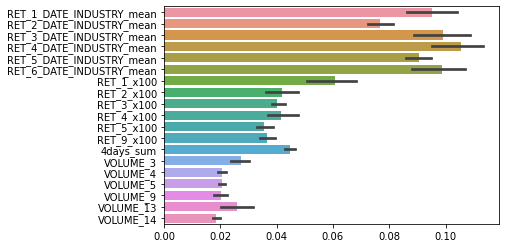

In [47]:
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)
sns.barplot(data=feature_importances, orient='h' )

In [ ]:
# RET_1,2_DATE_INDUSTRY_MEAN has some major impact in this particular feature set. 

## Train using difference Algorithm

### <<< Do not run >>>

### Support Vector Machine (SVC)

The algorithm cannot run on multiple cores, so it take more than 8h to train.

In [ ]:
X_train = train[features]
y_train = train[target]

train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = y_train.loc[local_test_ids]

    X_local_train = X_local_train.fillna(0)
    X_local_test = X_local_test.fillna(0)

    model = SVC(kernel='rbf', decision_function_shape='ovo',)
    model.fit(X_local_train, y_local_train)

    y_local_pred = model.predict_proba(X_local_test)[:, 1]
    
    sub = train.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

## Neural Net with SKlearn

In [ ]:
X_train = train[features]
y_train = train[target]
from sklearn.neural_network import MLPClassifier
# param of NN
rf_params = {
    'hidden_layer_sizes':(432,123),
    'activation':'relu',
    'solver':'sgd',
    'learning_rate':'constant',
    'learning_rate_init':0.005,
    'alpha': 0,
    'shuffle':False

}

train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = y_train.loc[local_test_ids]

    X_local_train = X_local_train.fillna(0)
    X_local_test = X_local_test.fillna(0)

    model = MLPClassifier(**rf_params)
    model.fit(X_local_train, y_local_train)
    print("Best loss ", model.best_loss_)
    y_local_pred = model.predict_proba(X_local_test)[:, 1]
    
    sub = train.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

## Neural Network with TF

In [17]:
# Training Data
X_train = train[features].fillna(0)
y_train = train[target]
# Convert y_train to one hot encoding
tf_y_train= pd.get_dummies(y_train)
 
 
model = Sequential()
model.add(Input(len(features),))
model.add(Dense(997, activation='relu' ,kernel_regularizer=l2(0.001)))
model.add(Dense(591, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dense(577, activation='relu', kernel_regularizer=l2(0.005)))  #L2 regularization for prevention overfitting
model.add(Dropout(0.3))   # 30% Dropout to prevent overfitting
model.add(Dense(2, activation='softmax'))
opt =SGD(learning_rate=0.05,momentum=0.5)
model.compile(optimizer = opt, loss='binary_crossentropy', metrics=['acc']  )
model.summary()
 
 
 
 
train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()
 
n_splits = 4
scores = []
models = []
 
splits = KFold(n_splits=n_splits, random_state=42,
               shuffle=True).split(train_dates)
 
for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]
 
    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)
 
    X_local_train = X_train.loc[local_train_ids]
    y_local_train = tf_y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = y_train.loc[local_test_ids]
    tf_y_local_test = tf_y_train.loc[local_test_ids]
 
    X_local_train = X_local_train.fillna(0)
    X_local_test = X_local_test.fillna(0)
 
    model.fit(X_local_train, y_local_train, batch_size= 2274 ,verbose=0, epochs=180)
 
    y_local_pred = model.predict(X_local_test)
    print(y_local_pred[0:2])
    sub = train.loc[local_test_ids].copy()
    sub["pred"] = y_local_pred[:, 1]

    y_local_pred = sub.groupby("DATE")["pred"].apply(lambda x: x > x.median()).values
 
    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    print(classification_report(y_local_test, y_local_pred))
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")
 
mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 997)               19940     
_________________________________________________________________
dense_5 (Dense)              (None, 591)               589818    
_________________________________________________________________
dense_6 (Dense)              (None, 577)               341584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 577)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 1156      
Total params: 952,498
Trainable params: 952,498
Non-trainable params: 0
_________________________________________________________________
[[0.505635   0.494365  ]
 [0.51940995 0.48059008]]
              precision    recall  f1-score   support

       F

## Creating batches in the group of date

In [ ]:
# Training Data
y_train = train["RET"]
# Convert y_train to one hot encoding
# encode class values as integers
train = pd.concat((train ,pd.get_dummies(y_train)), axis=1)
train.head()

In [ ]:
X_groupby = train.groupby(["DATE"])


In [ ]:
X_train = train[features]
y_train= train[target]
tf_y_train = pd.get_dummies(y_train)

"""
#Normalize training data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
"""




nnmodel = Sequential()
nnmodel.add(Input(len(features),))
nnmodel.add(Dense(300, activation='relu' ))
nnmodel.add(Dense(591, activation='relu',kernel_regularizer=l2(0.001)))
nnmodel.add(Dense(577, activation='relu', kernel_regularizer=l2(0.001)))
nnmodel.add(Dense(2, activation='sigmoid'))

# learning rate schedule
from tensorflow.keras.optimizers.schedules import ExponentialDecay
lr_schedule = ExponentialDecay(initial_learning_rate=2.0,
    decay_steps=10000,
    decay_rate=0.8)
opt =SGD(learning_rate=0.001,momentum=0.9)

adam =Adam(learning_rate=0.5)
nnmodel.compile(optimizer = opt, loss='binary_crossentropy', metrics= ['acc'])
nnmodel.summary()
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
import time
earlyStopping = EarlyStopping(monitor='val_acc', patience=15, verbose=1, mode='max', restore_best_weights=True)
mcp_save = ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_acc', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_acc', factor=0.6, patience=7, verbose=1, mode='min')
from time import sleep
from IPython.display import clear_output, display

for epoch in range(1,2):
  count = 0
  for key, batch in X_groupby:
    clear_output(wait=False)
    print("epoch:",epoch, "batch:",count/223)  # use display(f) if you encounter performance issues
    count+= 1
    sleep(10)

    X_batch = batch[features];
    y_batch = pd.concat((batch[False], batch[True]), axis=1)

history =nnmodel.train_on_batch(X_batch, y_batch)

"""
# summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
"""



In [ ]:
#Training set prediction
y_nnpred = nnmodel.predict(X_train)
sub = train.copy()
sub['pred_0'] = y_nnpred[:,0]
sub['pred_1'] = y_nnpred[:,1]
y_nnpredict = sub[['pred_0','pred_1']].apply(lambda x: True if x["pred_1"] > x["pred_0"] else False)
print(accuracy_score(y_train, y_nnpredict))

In [ ]:
# summarize history for loss
from tensorflow import keras
model = keras.models.load_model('mdl_wts.hdf5')

y_nnpred = model.predict(X_train.fillna(0))[:,1]
sub = train.copy()
sub['pred'] = y_nnpred
y_nnpredict = sub.groupby("DATE")['pred'].apply(lambda x: x > x.median())
print(accuracy_score(y_train, y_nnpredict))

## Training All data with Tensorflow neural network

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 991)               25766     
_________________________________________________________________
dense_1 (Dense)              (None, 551)               546592    
_________________________________________________________________
dense_2 (Dense)              (None, 577)               318504    
_________________________________________________________________
dropout (Dropout)            (None, 577)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1156      
Total params: 892,018
Trainable params: 892,018
Non-trainable params: 0
_________________________________________________________________
[[0.6185772  0.3814228 ]
 [0.6564353  0.34356463]]


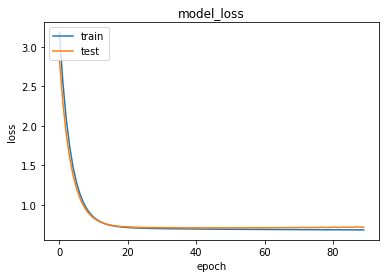

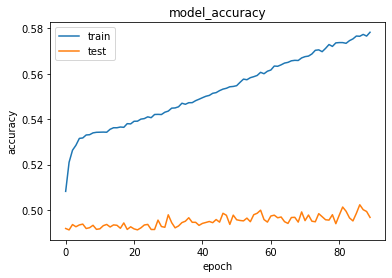

In [9]:
from matplotlib import pyplot as ppt
# Training Data
X_train = train[features].fillna(0)
y_train = train[target]
# Convert y_train to one hot encoding
tf_y_train= pd.get_dummies(y_train)
 
 
model = Sequential()
model.add(Input(len(features),))
model.add(Dense( 991, activation='relu' ,kernel_regularizer=l2(0.001)))
model.add(Dense(551, activation='relu', kernel_constraint=maxnorm(3)))
#model.add(Dropout(0.2))
model.add(Dense(577, activation='relu', kernel_regularizer=l2(0.005)))  #L2 regularization to prevent overfitting
model.add(Dropout(0.3))   # Drop out 30% to prevent overfitting
model.add(Dense(2, activation='softmax'))

opt =SGD(learning_rate=0.05,momentum=0.5)
model.compile(optimizer = opt, loss='binary_crossentropy', metrics=['acc']  )
model.summary()
 
history = model.fit(X_train, tf_y_train, epochs=90, verbose=0,shuffle=True, batch_size=2274, validation_split=0.2)
 
y_pred = model.predict(X_train)
print(y_pred[0:2])
sub = train.copy()

# Block for evaluation by using median
sub['pred'] = y_pred[:, 1]
y_pred = sub.groupby("DATE")['pred'].transform(lambda x: x > x.median()).values

# Block for evaluation by using max(True,False)
"""
sub["True"] = y_pred[:, 1]
sub["False"] = y_pred[:, 0]
 
y_pred = sub[["True", "False"]].apply(lambda x: True if x["True"] > x["False"] else False, axis=1)
print(classification_report(y_train, y_pred))
 """
# summarize history for loss
ppt.plot(history.history["loss"])
ppt.plot(history.history["val_loss"])
ppt.title('model_loss')
ppt.ylabel('loss')
ppt.xlabel('epoch')
ppt.legend(['train', 'test'], loc='upper left')
ppt.show()
 
# summarize history for accuracy
ppt.plot(history.history["acc"])
ppt.plot(history.history["val_acc"])
ppt.title('model_accuracy')
ppt.ylabel('accuracy')
ppt.xlabel('epoch')
ppt.legend(['train', 'test'], loc='upper left')
ppt.show()

### Verification of data accuracy on small portion of data (batching by "DATE")

Last DATE classification report by median
              precision    recall  f1-score   support

       False       0.52      0.52      0.52      1183
        True       0.52      0.52      0.52      1183

    accuracy                           0.52      2366
   macro avg       0.52      0.52      0.52      2366
weighted avg       0.52      0.52      0.52      2366

last Date Classification report max(True,False)
              precision    recall  f1-score   support

       False       0.51      0.72      0.60      1183
        True       0.53      0.32      0.40      1183

    accuracy                           0.52      2366
   macro avg       0.52      0.52      0.50      2366
weighted avg       0.52      0.52      0.50      2366

Min:[0.35268888], Mean:[0.57045494], Max:[0.70952381]
Min by max evaluation:[0.35301881], Mean by max evaluation:[0.56458939], Max by max evaluation:[0.70629371]


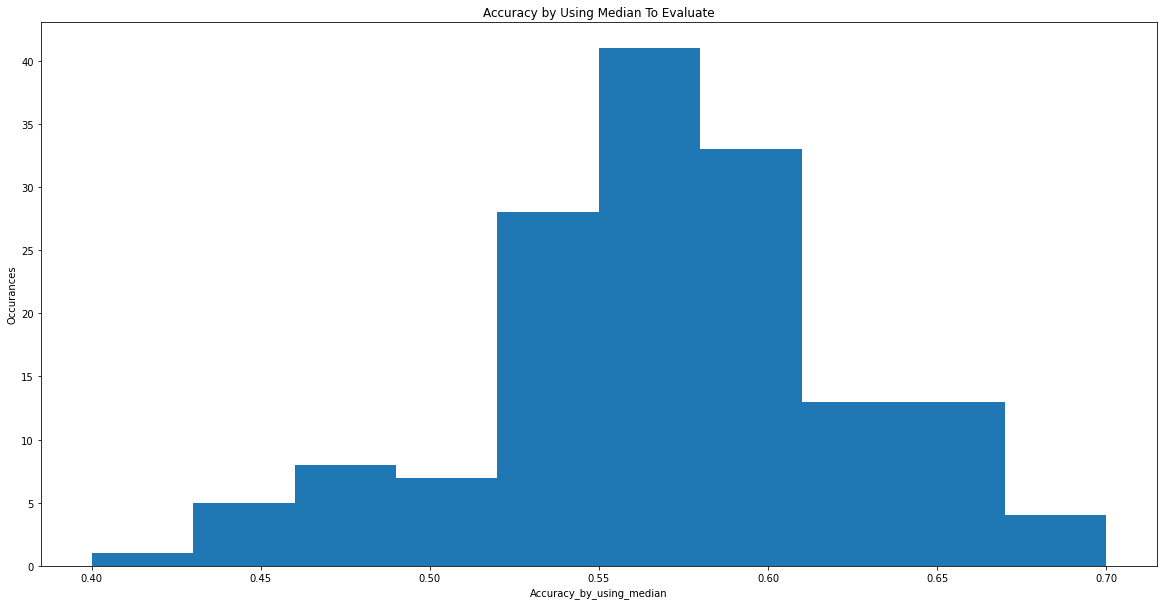

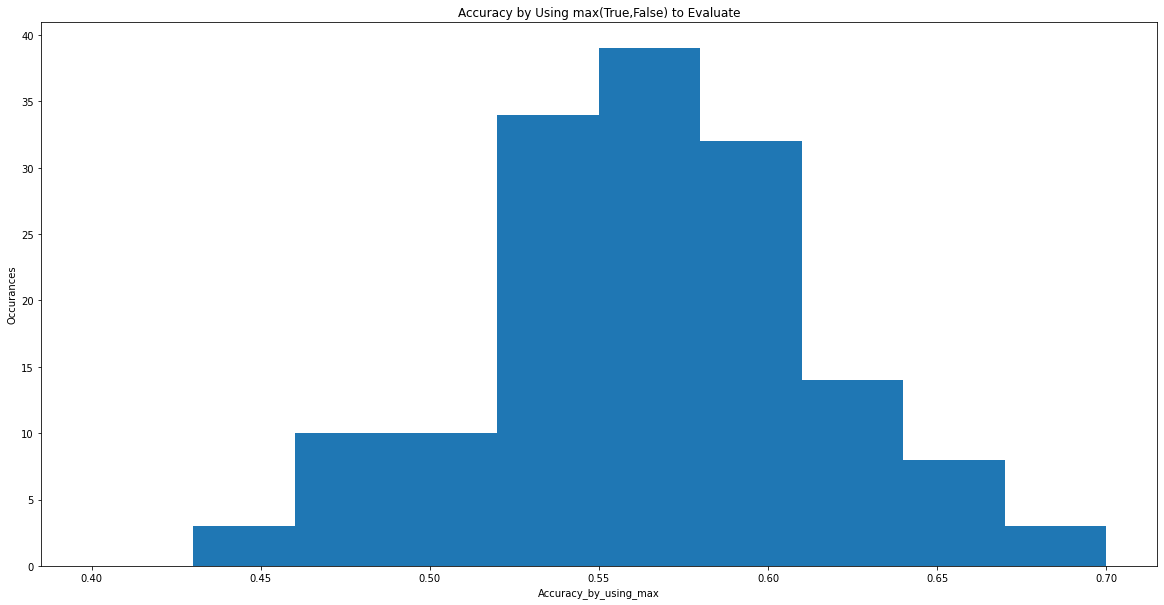

In [11]:
#Test for each date
accuracies=[]
accuraciesBy_max=[]
for date in train['DATE'].unique():
  #print(date)
  d0_df = train.loc[train['DATE'] == date]
  d0_y_pred= model.predict_proba(d0_df[features]);
  sub = d0_df.copy()
  sub["True"] = d0_y_pred[:, 1]
  sub["False"] = d0_y_pred[:, 0]
  sub['d0_pred'] = d0_y_pred[:,1]
  y_pred = sub[["True", "False"]].apply(lambda x: True if x["True"] > x["False"] else False, axis=1)
  d0_y_pred = sub['d0_pred'].transform(lambda x: x > x.median()).values

  acc = accuracy_score(d0_df[target], d0_y_pred)
  accuracies.append(acc)
  accuraciesBy_max.append(accuracy_score(d0_df[target],y_pred))
print("Last DATE classification report by median")
print(classification_report(d0_df[target], d0_y_pred))

print("last Date Classification report max(True,False)")
print(classification_report(d0_df[target], y_pred))

accuracies = pd.DataFrame(accuracies, columns=["Accuracy"])
accuraciesBy_max = pd.DataFrame(accuraciesBy_max, columns=["Accuracy"])
print("Min:{}, Mean:{}, Max:{}".format(accuracies.min().values,accuracies.mean().values,accuracies.max().values))
print("Min by max evaluation:{}, Mean by max evaluation:{}, Max by max evaluation:{}".format(accuraciesBy_max.min().values,accuraciesBy_max.mean().values,accuraciesBy_max.max().values))

ppt.figure(figsize=[20,10])
ppt.hist(accuracies["Accuracy"], range=(0.4,0.7))
ppt.title("Accuracy by Using Median To Evaluate")
ppt.xlabel('Accuracy_by_using_median')
ppt.ylabel('Occurances')
ppt.show()

ppt.figure(figsize=[20,10])
ppt.hist(accuraciesBy_max["Accuracy"], range=(0.4,0.7))
ppt.xlabel('Accuracy_by_using_max')
ppt.ylabel('Occurances')
ppt.title("Accuracy by Using max(True,False) to Evaluate")
ppt.show()


### Observation on Evaluation metrix
Evaluation by using median so separate data to 50% equally, give a slicely better accuracy than the result using max of the two output.

## Generate the submission

The same parameters of the RF model are considered. With that we build a new RF model on the entire `train` dataset. The predictions are saved in a `.csv` file.

In [ ]:
X_test = test[features]
X_train = train[features]
y_train = train[target]
rf_params = {
    'n_estimators': 721,
    'max_depth': 10,
    'random_state': 0,
    'criterion':'gini', # gini for impurity and entropy for information gain
    'min_samples_split':5,     #default 2, if float => min_sample_split*n_sample
    'min_samples_leaf':50,
    'n_jobs': -1
}
rf_params['random_state'] = 0
model = RandomForestClassifier(**rf_params)
model.fit(X_train.fillna(0), y_train)

y_pred = model.predict_proba(X_train.fillna(0))[:,1]

sub = train.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

print(accuracy_score(y_pred,y_train))
print(classification_report(y_pred,y_train))

In [ ]:
y_pred = model.predict(X_train.fillna(0))

sub = train.copy()
sub['pred'] = y_pred
y_preddict = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

print(accuracy_score(y_pred,y_train))
print(classification_report(y_pred,y_train))

In [ ]:
X_test = test[features].fillna(0)
print(X_test.shape)
y_pred = model.predict_proba(X_test)

sub = test.copy()
#sub['pred'] = y_pred
#y_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values
sub["True"] = y_pred[:, 1]
sub["False"] = y_pred[:, 0]
 
y_pred = sub[["True", "False"]].apply(lambda x: True if x["True"] > x["False"] else False, axis=1)
    
submission = pd.Series(y_pred)
submission.index = test.index
submission.name = target

submission.to_csv('/content/drive/My Drive/Colab Notebooks/result_19_NoGroupBy_Normalized_Neural_Net_qrt_.csv', index=True, header=True)

(198429, 26)


## Accuracy tracking during training

In [41]:
train_result = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Accuracy Tracking Sheet - Sheet1.csv", index_col='TryID', sep="," )
train_result

,Algorithm,Parameters,Fold_1_acc,Fold_2_acc,Fold_3_acc,Fold_4_acc,Training_acc,Testing_acc,Features,Comment
TryID,,,,,,,,,,
10,Random Forest,"n_estimator = 500, max_depth = 8, random_state...",50.75,50.61,52.98,52.77,57.00,51.52,"VOLUME_1 to 7 RET_1 - 7 *100, weighted_sum_ret...",NaN
11,Neural Network,"[997, 591, 577,2], learning_rate = 0.05, opt=S...",50.13,52.74,54.40,56.16,62.00,50.14,"VOLUME_1 to 7 RET_1 - 7 *100, weighted_sum_ret...",NaN
12,Random Forest,"n_estimator = 500, max_depth = 8, random_state...",50.59,50.79,53.37,52.37,56.48,51.47,"VOLUME_1 to 7 RET_1 - 7 *100, weighted_sum_ret...",RET_3_DATE_INDUSTRY is more important in the m...
13,Random Forest,"n_estimator = 500, max_depth = 8, random_state...",50.58,50.42,53.12,52.41,56.50,51.52,"VOLUME_1 to 10 RET_1 - 10 *100, weighted_sum_r...",NaN
13 (not groupby),Random Forest,"n_estimator = 500, max_depth = 8, random_state...",50.89,50.79,52.57,51.92,56.12,51.17,"VOLUME_1 to 10 RET_1 - 10 *100, weighted_sum_r...",NaN
14,Neural Network,"[997, 591, 577,2], dropout=0.2, learning_rate ...",49.63,53.98,59.88,63.51,63.00,50.72,"VOLUME_1 to 8 RET_1 - 8*100, weighted_sum_ret1...",NaN
15,Neural Network,"[997, 591, 577,2], dropout=0.2, learning_rate ...",59.59,53.82,60.29,63.40,60.00,50.50,"VOLUME_1 to 8 RET_1 - 8*100, weighted_sum_ret1...",RET_i replace by 0 and VOLUME_i replace by mean
16,Random Forest,"n_estimator = 551, max_depth = 15, criterion =...",51.55,51.02,51.08,51.26,70.93,51.22,"V_[3,4,5,9,11,13,14] RET_[2,3,4,5,11,13,14,19]...",NaN


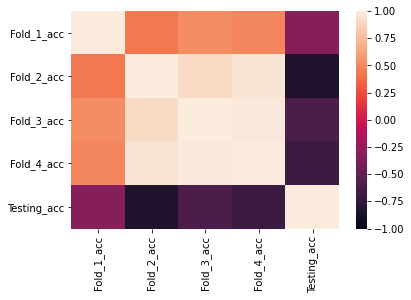

In [42]:
sns.heatmap(train_result[["Fold_1_acc","Fold_2_acc","Fold_3_acc","Fold_4_acc","Testing_acc"]].corr(), vmin=-1, vmax=1)

## Observation
The "Testing_acc" has negative correlation with accuracy from each CrossValidation Fold which mean if the accuracy in trainning increase the "Testing_acc" will be decrease. 

# Best result obtained
Algorithm : Random Forest 	
Parrameters : n_estimator = 500, max_depth = 8, random_state=0 </br>
CrossValidation result : 50.75 	50.61 	52.98 	52.77 </br>
Training Accuracy = 57.00  </br>
Testing Accuracy = 51.52 </br>
Features : VOLUME_1 to 7, RET_1 - 7 *100, weighted_sum_ret1-ret4, RET_1 to 2_DATE_INDUSTRY_mean